In [2]:
from time import time
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
import re
from nltk.corpus import stopwords
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import datetime

from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Merge, Lambda
import keras.backend as K
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint
import csv

Using TensorFlow backend.
/Users/jacek/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [ ]:
total = []

data_files = ['subtask_B_train_and_dev_dataset.csv', 'subtask_B_train_and_dev_generated_dataset.csv']

for file in data_files: 

    with open(file, 'r') as csvfile:
        csvreader = csv.reader(csvfile, delimiter=',', quotechar='"')
        next(csvreader, None)

        for row in csvreader:
            total.append(row)


In [ ]:
def return_without_idx(el):
    return el[1:]

updated_total = list(map(return_without_idx, total))

np.random.shuffle(updated_total)

In [ ]:
def label_to_class(val):
    if val == "Irrelevant":
        return 0
    return 1

In [ ]:
with open('train.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    
    writer.writerow(['id', 'qid1', 'qid2', 'question1', 'question2', 'relevance'])
    
    for idx, elem in enumerate(updated_total[:9000]):
        writer.writerow([idx, idx*2+1, idx*2+2, elem[2], elem[3], label_to_class(elem[4])])
    
with open('test.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    
    writer.writerow(['id', 'qid1', 'qid2', 'question1', 'question2', 'relevance'])
    
    for idx, elem in enumerate(updated_total[9000:]):
        writer.writerow([idx, idx*2+1, idx*2+2, elem[2], elem[3], label_to_class(elem[4])])


In [3]:
TRAIN_CSV = 'train.csv'
TEST_CSV = 'test.csv'
EMBEDDING_FILE = '../GoogleNews-vectors-negative300.bin.gz'
import pandas as pd
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)

stops = set(stopwords.words('english'))

In [27]:
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)

stops = set(stopwords.words('english'))

def text_to_word_list(text):
    ''' Pre process and convert texts to a list of words '''
    text = str(text)
    text = text.lower()

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    text = text.split()

    return text

vocabulary = dict()
inverse_vocabulary = ['<unk>']

print("Started loading google vectors...")
# '<unk>' will never be used, it is only a placeholder for the [0, 0, ....0] embedding
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

print("Finished loading google vectors...")

questions_cols = ['question1', 'question2']

# Iterate over the questions only of both training and test datasets
for dataset in [train_df, test_df]:
    for index, row in dataset.iterrows():
        


        # Iterate through the text of both questions of the row
        for question in questions_cols:
            
            print(index, question)
            
            q2n = []  # q2n -> question numbers representation
            for word in text_to_word_list(row[question]):
                
#                 print(word + "\n")

                # Check for unwanted words
                if word in stops and word not in word2vec.vocab:
                    continue

                if word not in vocabulary:
                    vocabulary[word] = len(inverse_vocabulary)
                    q2n.append(len(inverse_vocabulary))
                    inverse_vocabulary.append(word)
                else:
                    q2n.append(vocabulary[word])

            # Replace questions as word to question as number representation
            dataset.set_value(index, question, q2n)
            
embedding_dim = 300
embeddings = 1 * np.random.randn(len(vocabulary) + 1, embedding_dim)  # This will be the embedding matrix
embeddings[0] = 0  # So that the padding will be ignored

# Build the embedding matrix
for word, index in vocabulary.items():
    if word in word2vec.vocab:
        embeddings[index] = word2vec.word_vec(word)

del word2vec

Started loading google vectors...
Finished loading google vectors...
0 question1
0 question2
1 question1
1 question2
2 question1
2 question2
3 question1
3 question2
4 question1
4 question2
5 question1
5 question2
6 question1
6 question2
7 question1
7 question2
8 question1
8 question2
9 question1
9 question2
10 question1
10 question2
11 question1
11 question2
12 question1
12 question2
13 question1
13 question2
14 question1
14 question2
15 question1
15 question2
16 question1
16 question2
17 question1
17 question2
18 question1
18 question2
19 question1
19 question2
20 question1
20 question2
21 question1
21 question2
22 question1
22 question2
23 question1
23 question2
24 question1
24 question2
25 question1
25 question2
26 question1
26 question2
27 question1
27 question2
28 question1
28 question2
29 question1
29 question2
30 question1
30 question2
31 question1
31 question2
32 question1
32 question2
33 question1
33 question2
34 question1
34 question2
35 question1
35 question2
36 question1
36

366 question2
367 question1
367 question2
368 question1
368 question2
369 question1
369 question2
370 question1
370 question2
371 question1
371 question2
372 question1
372 question2
373 question1
373 question2
374 question1
374 question2
375 question1
375 question2
376 question1
376 question2
377 question1
377 question2
378 question1
378 question2
379 question1
379 question2
380 question1
380 question2
381 question1
381 question2
382 question1
382 question2
383 question1
383 question2
384 question1
384 question2
385 question1
385 question2
386 question1
386 question2
387 question1
387 question2
388 question1
388 question2
389 question1
389 question2
390 question1
390 question2
391 question1
391 question2
392 question1
392 question2
393 question1
393 question2
394 question1
394 question2
395 question1
395 question2
396 question1
396 question2
397 question1
397 question2
398 question1
398 question2
399 question1
399 question2
400 question1
400 question2
401 question1
401 question2
402 qu

868 question1
868 question2
869 question1
869 question2
870 question1
870 question2
871 question1
871 question2
872 question1
872 question2
873 question1
873 question2
874 question1
874 question2
875 question1
875 question2
876 question1
876 question2
877 question1
877 question2
878 question1
878 question2
879 question1
879 question2
880 question1
880 question2
881 question1
881 question2
882 question1
882 question2
883 question1
883 question2
884 question1
884 question2
885 question1
885 question2
886 question1
886 question2
887 question1
887 question2
888 question1
888 question2
889 question1
889 question2
890 question1
890 question2
891 question1
891 question2
892 question1
892 question2
893 question1
893 question2
894 question1
894 question2
895 question1
895 question2
896 question1
896 question2
897 question1
897 question2
898 question1
898 question2
899 question1
899 question2
900 question1
900 question2
901 question1
901 question2
902 question1
902 question2
903 question1
903 qu

1153 question1
1153 question2
1154 question1
1154 question2
1155 question1
1155 question2
1156 question1
1156 question2
1157 question1
1157 question2
1158 question1
1158 question2
1159 question1
1159 question2
1160 question1
1160 question2
1161 question1
1161 question2
1162 question1
1162 question2
1163 question1
1163 question2
1164 question1
1164 question2
1165 question1
1165 question2
1166 question1
1166 question2
1167 question1
1167 question2
1168 question1
1168 question2
1169 question1
1169 question2
1170 question1
1170 question2
1171 question1
1171 question2
1172 question1
1172 question2
1173 question1
1173 question2
1174 question1
1174 question2
1175 question1
1175 question2
1176 question1
1176 question2
1177 question1
1177 question2
1178 question1
1178 question2
1179 question1
1179 question2
1180 question1
1180 question2
1181 question1
1181 question2
1182 question1
1182 question2
1183 question1
1183 question2
1184 question1
1184 question2
1185 question1
1185 question2
1186 quest

1441 question2
1442 question1
1442 question2
1443 question1
1443 question2
1444 question1
1444 question2
1445 question1
1445 question2
1446 question1
1446 question2
1447 question1
1447 question2
1448 question1
1448 question2
1449 question1
1449 question2
1450 question1
1450 question2
1451 question1
1451 question2
1452 question1
1452 question2
1453 question1
1453 question2
1454 question1
1454 question2
1455 question1
1455 question2
1456 question1
1456 question2
1457 question1
1457 question2
1458 question1
1458 question2
1459 question1
1459 question2
1460 question1
1460 question2
1461 question1
1461 question2
1462 question1
1462 question2
1463 question1
1463 question2
1464 question1
1464 question2
1465 question1
1465 question2
1466 question1
1466 question2
1467 question1
1467 question2
1468 question1
1468 question2
1469 question1
1469 question2
1470 question1
1470 question2
1471 question1
1471 question2
1472 question1
1472 question2
1473 question1
1473 question2
1474 question1
1474 quest

1889 question2
1890 question1
1890 question2
1891 question1
1891 question2
1892 question1
1892 question2
1893 question1
1893 question2
1894 question1
1894 question2
1895 question1
1895 question2
1896 question1
1896 question2
1897 question1
1897 question2
1898 question1
1898 question2
1899 question1
1899 question2
1900 question1
1900 question2
1901 question1
1901 question2
1902 question1
1902 question2
1903 question1
1903 question2
1904 question1
1904 question2
1905 question1
1905 question2
1906 question1
1906 question2
1907 question1
1907 question2
1908 question1
1908 question2
1909 question1
1909 question2
1910 question1
1910 question2
1911 question1
1911 question2
1912 question1
1912 question2
1913 question1
1913 question2
1914 question1
1914 question2
1915 question1
1915 question2
1916 question1
1916 question2
1917 question1
1917 question2
1918 question1
1918 question2
1919 question1
1919 question2
1920 question1
1920 question2
1921 question1
1921 question2
1922 question1
1922 quest

2356 question2
2357 question1
2357 question2
2358 question1
2358 question2
2359 question1
2359 question2
2360 question1
2360 question2
2361 question1
2361 question2
2362 question1
2362 question2
2363 question1
2363 question2
2364 question1
2364 question2
2365 question1
2365 question2
2366 question1
2366 question2
2367 question1
2367 question2
2368 question1
2368 question2
2369 question1
2369 question2
2370 question1
2370 question2
2371 question1
2371 question2
2372 question1
2372 question2
2373 question1
2373 question2
2374 question1
2374 question2
2375 question1
2375 question2
2376 question1
2376 question2
2377 question1
2377 question2
2378 question1
2378 question2
2379 question1
2379 question2
2380 question1
2380 question2
2381 question1
2381 question2
2382 question1
2382 question2
2383 question1
2383 question2
2384 question1
2384 question2
2385 question1
2385 question2
2386 question1
2386 question2
2387 question1
2387 question2
2388 question1
2388 question2
2389 question1
2389 quest

2847 question2
2848 question1
2848 question2
2849 question1
2849 question2
2850 question1
2850 question2
2851 question1
2851 question2
2852 question1
2852 question2
2853 question1
2853 question2
2854 question1
2854 question2
2855 question1
2855 question2
2856 question1
2856 question2
2857 question1
2857 question2
2858 question1
2858 question2
2859 question1
2859 question2
2860 question1
2860 question2
2861 question1
2861 question2
2862 question1
2862 question2
2863 question1
2863 question2
2864 question1
2864 question2
2865 question1
2865 question2
2866 question1
2866 question2
2867 question1
2867 question2
2868 question1
2868 question2
2869 question1
2869 question2
2870 question1
2870 question2
2871 question1
2871 question2
2872 question1
2872 question2
2873 question1
2873 question2
2874 question1
2874 question2
2875 question1
2875 question2
2876 question1
2876 question2
2877 question1
2877 question2
2878 question1
2878 question2
2879 question1
2879 question2
2880 question1
2880 quest

3238 question2
3239 question1
3239 question2
3240 question1
3240 question2
3241 question1
3241 question2
3242 question1
3242 question2
3243 question1
3243 question2
3244 question1
3244 question2
3245 question1
3245 question2
3246 question1
3246 question2
3247 question1
3247 question2
3248 question1
3248 question2
3249 question1
3249 question2
3250 question1
3250 question2
3251 question1
3251 question2
3252 question1
3252 question2
3253 question1
3253 question2
3254 question1
3254 question2
3255 question1
3255 question2
3256 question1
3256 question2
3257 question1
3257 question2
3258 question1
3258 question2
3259 question1
3259 question2
3260 question1
3260 question2
3261 question1
3261 question2
3262 question1
3262 question2
3263 question1
3263 question2
3264 question1
3264 question2
3265 question1
3265 question2
3266 question1
3266 question2
3267 question1
3267 question2
3268 question1
3268 question2
3269 question1
3269 question2
3270 question1
3270 question2
3271 question1
3271 quest

3713 question1
3713 question2
3714 question1
3714 question2
3715 question1
3715 question2
3716 question1
3716 question2
3717 question1
3717 question2
3718 question1
3718 question2
3719 question1
3719 question2
3720 question1
3720 question2
3721 question1
3721 question2
3722 question1
3722 question2
3723 question1
3723 question2
3724 question1
3724 question2
3725 question1
3725 question2
3726 question1
3726 question2
3727 question1
3727 question2
3728 question1
3728 question2
3729 question1
3729 question2
3730 question1
3730 question2
3731 question1
3731 question2
3732 question1
3732 question2
3733 question1
3733 question2
3734 question1
3734 question2
3735 question1
3735 question2
3736 question1
3736 question2
3737 question1
3737 question2
3738 question1
3738 question2
3739 question1
3739 question2
3740 question1
3740 question2
3741 question1
3741 question2
3742 question1
3742 question2
3743 question1
3743 question2
3744 question1
3744 question2
3745 question1
3745 question2
3746 quest

4111 question1
4111 question2
4112 question1
4112 question2
4113 question1
4113 question2
4114 question1
4114 question2
4115 question1
4115 question2
4116 question1
4116 question2
4117 question1
4117 question2
4118 question1
4118 question2
4119 question1
4119 question2
4120 question1
4120 question2
4121 question1
4121 question2
4122 question1
4122 question2
4123 question1
4123 question2
4124 question1
4124 question2
4125 question1
4125 question2
4126 question1
4126 question2
4127 question1
4127 question2
4128 question1
4128 question2
4129 question1
4129 question2
4130 question1
4130 question2
4131 question1
4131 question2
4132 question1
4132 question2
4133 question1
4133 question2
4134 question1
4134 question2
4135 question1
4135 question2
4136 question1
4136 question2
4137 question1
4137 question2
4138 question1
4138 question2
4139 question1
4139 question2
4140 question1
4140 question2
4141 question1
4141 question2
4142 question1
4142 question2
4143 question1
4143 question2
4144 quest

4604 question2
4605 question1
4605 question2
4606 question1
4606 question2
4607 question1
4607 question2
4608 question1
4608 question2
4609 question1
4609 question2
4610 question1
4610 question2
4611 question1
4611 question2
4612 question1
4612 question2
4613 question1
4613 question2
4614 question1
4614 question2
4615 question1
4615 question2
4616 question1
4616 question2
4617 question1
4617 question2
4618 question1
4618 question2
4619 question1
4619 question2
4620 question1
4620 question2
4621 question1
4621 question2
4622 question1
4622 question2
4623 question1
4623 question2
4624 question1
4624 question2
4625 question1
4625 question2
4626 question1
4626 question2
4627 question1
4627 question2
4628 question1
4628 question2
4629 question1
4629 question2
4630 question1
4630 question2
4631 question1
4631 question2
4632 question1
4632 question2
4633 question1
4633 question2
4634 question1
4634 question2
4635 question1
4635 question2
4636 question1
4636 question2
4637 question1
4637 quest

5106 question2
5107 question1
5107 question2
5108 question1
5108 question2
5109 question1
5109 question2
5110 question1
5110 question2
5111 question1
5111 question2
5112 question1
5112 question2
5113 question1
5113 question2
5114 question1
5114 question2
5115 question1
5115 question2
5116 question1
5116 question2
5117 question1
5117 question2
5118 question1
5118 question2
5119 question1
5119 question2
5120 question1
5120 question2
5121 question1
5121 question2
5122 question1
5122 question2
5123 question1
5123 question2
5124 question1
5124 question2
5125 question1
5125 question2
5126 question1
5126 question2
5127 question1
5127 question2
5128 question1
5128 question2
5129 question1
5129 question2
5130 question1
5130 question2
5131 question1
5131 question2
5132 question1
5132 question2
5133 question1
5133 question2
5134 question1
5134 question2
5135 question1
5135 question2
5136 question1
5136 question2
5137 question1
5137 question2
5138 question1
5138 question2
5139 question1
5139 quest

5563 question2
5564 question1
5564 question2
5565 question1
5565 question2
5566 question1
5566 question2
5567 question1
5567 question2
5568 question1
5568 question2
5569 question1
5569 question2
5570 question1
5570 question2
5571 question1
5571 question2
5572 question1
5572 question2
5573 question1
5573 question2
5574 question1
5574 question2
5575 question1
5575 question2
5576 question1
5576 question2
5577 question1
5577 question2
5578 question1
5578 question2
5579 question1
5579 question2
5580 question1
5580 question2
5581 question1
5581 question2
5582 question1
5582 question2
5583 question1
5583 question2
5584 question1
5584 question2
5585 question1
5585 question2
5586 question1
5586 question2
5587 question1
5587 question2
5588 question1
5588 question2
5589 question1
5589 question2
5590 question1
5590 question2
5591 question1
5591 question2
5592 question1
5592 question2
5593 question1
5593 question2
5594 question1
5594 question2
5595 question1
5595 question2
5596 question1
5596 quest

5983 question2
5984 question1
5984 question2
5985 question1
5985 question2
5986 question1
5986 question2
5987 question1
5987 question2
5988 question1
5988 question2
5989 question1
5989 question2
5990 question1
5990 question2
5991 question1
5991 question2
5992 question1
5992 question2
5993 question1
5993 question2
5994 question1
5994 question2
5995 question1
5995 question2
5996 question1
5996 question2
5997 question1
5997 question2
5998 question1
5998 question2
5999 question1
5999 question2
6000 question1
6000 question2
6001 question1
6001 question2
6002 question1
6002 question2
6003 question1
6003 question2
6004 question1
6004 question2
6005 question1
6005 question2
6006 question1
6006 question2
6007 question1
6007 question2
6008 question1
6008 question2
6009 question1
6009 question2
6010 question1
6010 question2
6011 question1
6011 question2
6012 question1
6012 question2
6013 question1
6013 question2
6014 question1
6014 question2
6015 question1
6015 question2
6016 question1
6016 quest

6494 question1
6494 question2
6495 question1
6495 question2
6496 question1
6496 question2
6497 question1
6497 question2
6498 question1
6498 question2
6499 question1
6499 question2
6500 question1
6500 question2
6501 question1
6501 question2
6502 question1
6502 question2
6503 question1
6503 question2
6504 question1
6504 question2
6505 question1
6505 question2
6506 question1
6506 question2
6507 question1
6507 question2
6508 question1
6508 question2
6509 question1
6509 question2
6510 question1
6510 question2
6511 question1
6511 question2
6512 question1
6512 question2
6513 question1
6513 question2
6514 question1
6514 question2
6515 question1
6515 question2
6516 question1
6516 question2
6517 question1
6517 question2
6518 question1
6518 question2
6519 question1
6519 question2
6520 question1
6520 question2
6521 question1
6521 question2
6522 question1
6522 question2
6523 question1
6523 question2
6524 question1
6524 question2
6525 question1
6525 question2
6526 question1
6526 question2
6527 quest

6981 question1
6981 question2
6982 question1
6982 question2
6983 question1
6983 question2
6984 question1
6984 question2
6985 question1
6985 question2
6986 question1
6986 question2
6987 question1
6987 question2
6988 question1
6988 question2
6989 question1
6989 question2
6990 question1
6990 question2
6991 question1
6991 question2
6992 question1
6992 question2
6993 question1
6993 question2
6994 question1
6994 question2
6995 question1
6995 question2
6996 question1
6996 question2
6997 question1
6997 question2
6998 question1
6998 question2
6999 question1
6999 question2
7000 question1
7000 question2
7001 question1
7001 question2
7002 question1
7002 question2
7003 question1
7003 question2
7004 question1
7004 question2
7005 question1
7005 question2
7006 question1
7006 question2
7007 question1
7007 question2
7008 question1
7008 question2
7009 question1
7009 question2
7010 question1
7010 question2
7011 question1
7011 question2
7012 question1
7012 question2
7013 question1
7013 question2
7014 quest

7391 question1
7391 question2
7392 question1
7392 question2
7393 question1
7393 question2
7394 question1
7394 question2
7395 question1
7395 question2
7396 question1
7396 question2
7397 question1
7397 question2
7398 question1
7398 question2
7399 question1
7399 question2
7400 question1
7400 question2
7401 question1
7401 question2
7402 question1
7402 question2
7403 question1
7403 question2
7404 question1
7404 question2
7405 question1
7405 question2
7406 question1
7406 question2
7407 question1
7407 question2
7408 question1
7408 question2
7409 question1
7409 question2
7410 question1
7410 question2
7411 question1
7411 question2
7412 question1
7412 question2
7413 question1
7413 question2
7414 question1
7414 question2
7415 question1
7415 question2
7416 question1
7416 question2
7417 question1
7417 question2
7418 question1
7418 question2
7419 question1
7419 question2
7420 question1
7420 question2
7421 question1
7421 question2
7422 question1
7422 question2
7423 question1
7423 question2
7424 quest

7851 question2
7852 question1
7852 question2
7853 question1
7853 question2
7854 question1
7854 question2
7855 question1
7855 question2
7856 question1
7856 question2
7857 question1
7857 question2
7858 question1
7858 question2
7859 question1
7859 question2
7860 question1
7860 question2
7861 question1
7861 question2
7862 question1
7862 question2
7863 question1
7863 question2
7864 question1
7864 question2
7865 question1
7865 question2
7866 question1
7866 question2
7867 question1
7867 question2
7868 question1
7868 question2
7869 question1
7869 question2
7870 question1
7870 question2
7871 question1
7871 question2
7872 question1
7872 question2
7873 question1
7873 question2
7874 question1
7874 question2
7875 question1
7875 question2
7876 question1
7876 question2
7877 question1
7877 question2
7878 question1
7878 question2
7879 question1
7879 question2
7880 question1
7880 question2
7881 question1
7881 question2
7882 question1
7882 question2
7883 question1
7883 question2
7884 question1
7884 quest

8250 question2
8251 question1
8251 question2
8252 question1
8252 question2
8253 question1
8253 question2
8254 question1
8254 question2
8255 question1
8255 question2
8256 question1
8256 question2
8257 question1
8257 question2
8258 question1
8258 question2
8259 question1
8259 question2
8260 question1
8260 question2
8261 question1
8261 question2
8262 question1
8262 question2
8263 question1
8263 question2
8264 question1
8264 question2
8265 question1
8265 question2
8266 question1
8266 question2
8267 question1
8267 question2
8268 question1
8268 question2
8269 question1
8269 question2
8270 question1
8270 question2
8271 question1
8271 question2
8272 question1
8272 question2
8273 question1
8273 question2
8274 question1
8274 question2
8275 question1
8275 question2
8276 question1
8276 question2
8277 question1
8277 question2
8278 question1
8278 question2
8279 question1
8279 question2
8280 question1
8280 question2
8281 question1
8281 question2
8282 question1
8282 question2
8283 question1
8283 quest

8735 question1
8735 question2
8736 question1
8736 question2
8737 question1
8737 question2
8738 question1
8738 question2
8739 question1
8739 question2
8740 question1
8740 question2
8741 question1
8741 question2
8742 question1
8742 question2
8743 question1
8743 question2
8744 question1
8744 question2
8745 question1
8745 question2
8746 question1
8746 question2
8747 question1
8747 question2
8748 question1
8748 question2
8749 question1
8749 question2
8750 question1
8750 question2
8751 question1
8751 question2
8752 question1
8752 question2
8753 question1
8753 question2
8754 question1
8754 question2
8755 question1
8755 question2
8756 question1
8756 question2
8757 question1
8757 question2
8758 question1
8758 question2
8759 question1
8759 question2
8760 question1
8760 question2
8761 question1
8761 question2
8762 question1
8762 question2
8763 question1
8763 question2
8764 question1
8764 question2
8765 question1
8765 question2
8766 question1
8766 question2
8767 question1
8767 question2
8768 quest

224 question1
224 question2
225 question1
225 question2
226 question1
226 question2
227 question1
227 question2
228 question1
228 question2
229 question1
229 question2
230 question1
230 question2
231 question1
231 question2
232 question1
232 question2
233 question1
233 question2
234 question1
234 question2
235 question1
235 question2
236 question1
236 question2
237 question1
237 question2
238 question1
238 question2
239 question1
239 question2
240 question1
240 question2
241 question1
241 question2
242 question1
242 question2
243 question1
243 question2
244 question1
244 question2
245 question1
245 question2
246 question1
246 question2
247 question1
247 question2
248 question1
248 question2
249 question1
249 question2
250 question1
250 question2
251 question1
251 question2
252 question1
252 question2
253 question1
253 question2
254 question1
254 question2
255 question1
255 question2
256 question1
256 question2
257 question1
257 question2
258 question1
258 question2
259 question1
259 qu

623 question1
623 question2
624 question1
624 question2
625 question1
625 question2
626 question1
626 question2
627 question1
627 question2
628 question1
628 question2
629 question1
629 question2
630 question1
630 question2
631 question1
631 question2
632 question1
632 question2
633 question1
633 question2
634 question1
634 question2
635 question1
635 question2
636 question1
636 question2
637 question1
637 question2
638 question1
638 question2
639 question1
639 question2
640 question1
640 question2
641 question1
641 question2
642 question1
642 question2
643 question1
643 question2
644 question1
644 question2
645 question1
645 question2
646 question1
646 question2
647 question1
647 question2
648 question1
648 question2
649 question1
649 question2
650 question1
650 question2
651 question1
651 question2
652 question1
652 question2
653 question1
653 question2
654 question1
654 question2
655 question1
655 question2
656 question1
656 question2
657 question1
657 question2
658 question1
658 qu

1108 question1
1108 question2
1109 question1
1109 question2
1110 question1
1110 question2
1111 question1
1111 question2
1112 question1
1112 question2
1113 question1
1113 question2
1114 question1
1114 question2
1115 question1
1115 question2
1116 question1
1116 question2
1117 question1
1117 question2
1118 question1
1118 question2
1119 question1
1119 question2
1120 question1
1120 question2
1121 question1
1121 question2
1122 question1
1122 question2
1123 question1
1123 question2
1124 question1
1124 question2
1125 question1
1125 question2
1126 question1
1126 question2
1127 question1
1127 question2
1128 question1
1128 question2
1129 question1
1129 question2
1130 question1
1130 question2
1131 question1
1131 question2
1132 question1
1132 question2
1133 question1
1133 question2
1134 question1
1134 question2
1135 question1
1135 question2
1136 question1
1136 question2
1137 question1
1137 question2
1138 question1
1138 question2
1139 question1
1139 question2
1140 question1
1140 question2
1141 quest

1506 question2
1507 question1
1507 question2
1508 question1
1508 question2
1509 question1
1509 question2
1510 question1
1510 question2
1511 question1
1511 question2
1512 question1
1512 question2
1513 question1
1513 question2
1514 question1
1514 question2
1515 question1
1515 question2
1516 question1
1516 question2
1517 question1
1517 question2
1518 question1
1518 question2
1519 question1
1519 question2
1520 question1
1520 question2
1521 question1
1521 question2
1522 question1
1522 question2
1523 question1
1523 question2
1524 question1
1524 question2
1525 question1
1525 question2
1526 question1
1526 question2
1527 question1
1527 question2
1528 question1
1528 question2
1529 question1
1529 question2
1530 question1
1530 question2
1531 question1
1531 question2
1532 question1
1532 question2
1533 question1
1533 question2
1534 question1
1534 question2
1535 question1
1535 question2
1536 question1
1536 question2
1537 question1
1537 question2
1538 question1
1538 question2
1539 question1
1539 quest

1785 question1
1785 question2
1786 question1
1786 question2
1787 question1
1787 question2
1788 question1
1788 question2
1789 question1
1789 question2
1790 question1
1790 question2
1791 question1
1791 question2
1792 question1
1792 question2
1793 question1
1793 question2
1794 question1
1794 question2
1795 question1
1795 question2
1796 question1
1796 question2
1797 question1
1797 question2
1798 question1
1798 question2
1799 question1
1799 question2
1800 question1
1800 question2
1801 question1
1801 question2
1802 question1
1802 question2
1803 question1
1803 question2
1804 question1
1804 question2
1805 question1
1805 question2
1806 question1
1806 question2
1807 question1
1807 question2
1808 question1
1808 question2
1809 question1
1809 question2
1810 question1
1810 question2
1811 question1
1811 question2
1812 question1
1812 question2
1813 question1
1813 question2
1814 question1
1814 question2
1815 question1
1815 question2
1816 question1
1816 question2
1817 question1
1817 question2
1818 quest

2267 question2
2268 question1
2268 question2
2269 question1
2269 question2
2270 question1
2270 question2
2271 question1
2271 question2
2272 question1
2272 question2
2273 question1
2273 question2
2274 question1
2274 question2
2275 question1
2275 question2
2276 question1
2276 question2
2277 question1
2277 question2
2278 question1
2278 question2
2279 question1
2279 question2
2280 question1
2280 question2
2281 question1
2281 question2
2282 question1
2282 question2
2283 question1
2283 question2
2284 question1
2284 question2
2285 question1
2285 question2
2286 question1
2286 question2
2287 question1
2287 question2
2288 question1
2288 question2
2289 question1
2289 question2
2290 question1
2290 question2
2291 question1
2291 question2
2292 question1
2292 question2
2293 question1
2293 question2
2294 question1
2294 question2
2295 question1
2295 question2
2296 question1
2296 question2
2297 question1
2297 question2
2298 question1
2298 question2
2299 question1
2299 question2
2300 question1
2300 quest

In [30]:
questions_cols = ['question1', 'question2']
max_seq_length = max(train_df.question1.map(lambda x: len(x)).max(),
                     train_df.question2.map(lambda x: len(x)).max(),
                     test_df.question1.map(lambda x: len(x)).max(),
                     test_df.question2.map(lambda x: len(x)).max())

print(max_seq_length)
# Split to train validation
validation_size = 900
training_size = len(train_df) - validation_size

X = train_df[questions_cols]
Y = train_df['relevance']

X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size)

print("splitting to docs")
# Split to dicts
X_train = {'left': X_train.question1, 'right': X_train.question2}
X_validation = {'left': X_validation.question1, 'right': X_validation.question2}
X_test = {'left': test_df.question1, 'right': test_df.question2}

# Convert labels to their numpy representations
Y_train = Y_train.values
Y_validation = Y_validation.values

# Zero padding


for dataset, side in itertools.product([X_train, X_validation], ['left', 'right']):
    print("padding...")
    
    dataset[side] = pad_sequences(dataset[side], maxlen=max_seq_length)

# # Make sure everything is ok
assert X_train['left'].shape == X_train['right'].shape
assert len(X_train['left']) == len(Y_train)

107
splitting to docs
padding...
padding...
padding...
padding...


In [31]:
# Model variables
n_hidden = 50
gradient_clipping_norm = 1.25
batch_size = 64
n_epoch = 20


def _my_out_shape(shapes):
    return (shapes[0][0], 1);

def _exponent_neg_manhattan_distance(lay):
    '''Overriden exponent manhattan distance function'''
    return K.exp(-K.sum(K.abs(lay[0]-lay[1]), axis=1, keepdims=True))

def exponent_neg_manhattan_distance(left, right):
    ''' Helper function for the similarity estimate of the LSTMs outputs'''
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

# The visible layer
left_input = Input(shape=(max_seq_length,), dtype='int32')
right_input = Input(shape=(max_seq_length,), dtype='int32')

embedding_layer = Embedding(len(embeddings), embedding_dim, weights=[embeddings], input_length=max_seq_length, trainable=False)

# Embedded version of the inputs
encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)

# Since this is a siamese network, both sides share the same LSTM
shared_lstm = LSTM(n_hidden)

left_output = shared_lstm(encoded_left)
right_output = shared_lstm(encoded_right)

malstm_distance = Lambda(_exponent_neg_manhattan_distance, output_shape=_my_out_shape)([left_output, right_output])
# Calculates the distance as defined by the MaLSTM model
# malstm_distance = Merge(mode=lambda x: exponent_neg_manhattan_distance(x[0], x[1]), output_shape=lambda x: (x[0][0], 1))([left_output, right_output])

# Pack it all up into a model
malstm = Model([left_input, right_input], [malstm_distance])

# Adadelta optimizer, with gradient clipping by norm
optimizer = Adadelta(clipnorm=gradient_clipping_norm)

malstm.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])



In [71]:
# Start training
training_start_time = time()

malstm_trained = malstm.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, epochs=10,
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation))

print("Training time finished.\n{} epochs in {}".format(n_epoch, datetime.timedelta(seconds=time()-training_start_time)))

Train on 8100 samples, validate on 900 samples
Epoch 1/10
8100/8100 [==============================] - 39s 5ms/step - loss: 0.0881 - acc: 0.9251 - val_loss: 0.1240 - val_acc: 0.8478
Epoch 2/10
8100/8100 [==============================] - 38s 5ms/step - loss: 0.0865 - acc: 0.9285 - val_loss: 0.1225 - val_acc: 0.8467
Epoch 3/10
8100/8100 [==============================] - 38s 5ms/step - loss: 0.0859 - acc: 0.9296 - val_loss: 0.1221 - val_acc: 0.8533
Epoch 4/10
8100/8100 [==============================] - 39s 5ms/step - loss: 0.0855 - acc: 0.9274 - val_loss: 0.1238 - val_acc: 0.8467
Epoch 5/10
8100/8100 [==============================] - 38s 5ms/step - loss: 0.0849 - acc: 0.9281 - val_loss: 0.1211 - val_acc: 0.8533
Epoch 6/10
8100/8100 [==============================] - 38s 5ms/step - loss: 0.0840 - acc: 0.9322 - val_loss: 0.1225 - val_acc: 0.8500
Epoch 7/10
8100/8100 [==============================] - 38s 5ms/step - loss: 0.0836 - acc: 0.9312 - val_loss: 0.1197 - val_acc: 0.8567
Epoch 8/

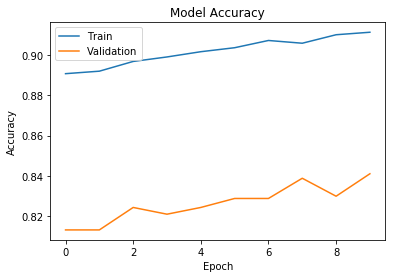

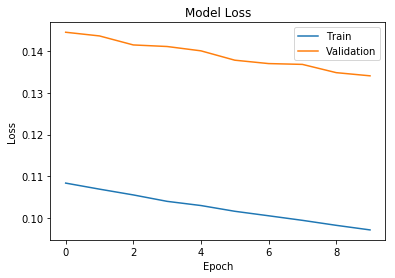

In [69]:
plt.plot(malstm_trained.history['acc'])
plt.plot(malstm_trained.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(malstm_trained.history['loss'])
plt.plot(malstm_trained.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [37]:
Y_test = test_df['relevance']
X_test['left'] = pad_sequences(X_test['left'], maxlen=max_seq_length)
X_test['right'] = pad_sequences(X_test['right'], maxlen=max_seq_length)

# # Make sure everything is ok
assert X_test['left'].shape == X_test['right'].shape
assert len(X_test['left']) == len(Y_test)


In [74]:
score_malstm = malstm.evaluate([X_test['left'], X_test['right']], Y_test, batch_size=32, verbose=1, sample_weight=None)

2395/2395 [==============================] - 6s 2ms/step


In [91]:
malstm.save("model_sobota")

In [73]:
Y_pred = malstm.predict([X_test['left'], X_test['right']])


In [75]:
score_malstm

[0.10706617019308384, 0.87348643013729188]

In [87]:
Y_pred_mapped = list(map(give_class, Y_pred))

In [86]:
def give_class(x):
    return 1 if x>0.55 else 0
        

In [88]:
prediction_metric = metrics.precision_score(Y_test, Y_pred_mapped)
recall_metric = metrics.recall_score(Y_test, Y_pred_mapped)
roc_metric = metrics.roc_auc_score(Y_test, Y_pred_mapped)

f1_metric = metrics.f1_score(Y_test, Y_pred_mapped)

In [80]:
print(prediction_metric, recall_metric, roc_metric, f1_metric) # 0.5

0.860269360269 0.699042407661 0.824581299984 0.771320754717


In [85]:
print(prediction_metric, recall_metric, roc_metric, f1_metric) # 0.4

0.797619047619 0.824897400821 0.866475142718 0.811028917283


In [59]:
print(prediction_metric, recall_metric, roc_metric, f1_metric) # 0.3

0.634634634635 0.86730506156 0.823977050011 0.732947976879


In [89]:
print(prediction_metric, recall_metric, roc_metric, f1_metric) # 0.55

0.892929292929 0.604651162791 0.786400100626 0.721044045677


In [67]:
print(prediction_metric, recall_metric, roc_metric, f1_metric) # 0.6

0.952631578947 0.247606019152 0.621098682653 0.393051031488
